In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

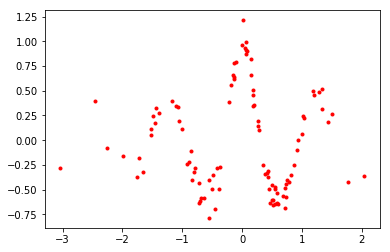

In [2]:
# Make toy dataset
n_sample = 100
X = np.random.normal(size=(n_sample,1))
Y = np.random.normal(np.cos(5.*X)/(np.abs(X)+1.), 0.1)
X_pred = np.atleast_2d(np.linspace(-3,3,num=100)).T
plt.figure(0)
plt.plot(X,Y,'r.')
plt.show()
plt.close()

In [3]:
# Build the model
X_ = tf.placeholder(tf.float32, shape=[None, 1])
Y_ = tf.placeholder(tf.float32, shape=[None, 1])
alpha_ = tf.placeholder(tf.float32, [])

x_in = tf.keras.Input(tensor=X_)
x = tfp.layers.DenseFlipout(50,activation='relu')(x_in)
x = tfp.layers.DenseFlipout(50,activation='relu')(x)
x_out = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs=x_in,outputs=x_out)

norm = tfp.distributions.Normal(Y_, 0.1)
log_likelihood = tf.reduce_sum(norm.log_prob(x_out))
kl = sum(model.losses)
elbo_loss = -log_likelihood + kl*alpha_
# 如果把这个kl loss项注释掉，那么随着训练迭代，随机抽样的模型不会在不确定区域表现出波动性。
# 推测如果没有 kl,通过学习，权重的方差在学习过程中会越来越小，趋于0，最后权重会变成确定性的
train_op = tf.train.AdamOptimizer(0.001).minimize(elbo_loss)
mse = tf.reduce_sum(tf.square(Y_-x_out))/n_sample

In [4]:
def draw(xtr, ytr, xte, yte):
    xtr = np.squeeze(xtr)
    ytr = np.squeeze(ytr)
    xte = np.squeeze(xte)
    yte = np.squeeze(yte)
#     print(xtr.shape, ytr.shape, xte.shape, yte.shape)
    plt.figure(0)
    plt.plot(xtr, ytr, 'r.')
    for j in range(yte.shape[0]):
        plt.plot(xte, yte[j], 'b-', alpha=0.1)
    plt.show()
    plt.close()

def main(alpha = 0):
    print('alpha={}'.format(alpha))
    # Train the model
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    for i in range(50001):
        [tr_mse, _] = sess.run([mse,train_op], feed_dict={X_:X, Y_: Y, alpha_:alpha})
        if i % 10000 == 0:
            print('train step:{}, train loss:{}'.format(i, tr_mse))
    Y_pred = np.zeros([20, X_pred.shape[0]])
    for j in range(20):
        Y_pred[j,:] = np.squeeze(sess.run(x_out, feed_dict={X_:X_pred}))
    draw(X, Y, X_pred, Y_pred)

BayesNN 中优化的 loss 有两项：$Loss = Loss_{CE} + \alpha\times Loss_{KL}$，下面变化 $\alpha$ 的值，测试输出。
- 如果 $Loss_{KL}$ 的权重为0
    - 模型可以较好地拟合孤立点
    - 模型经过多次抽样，会表现出较小的波动
- 如果 $Loss_{KL}$ 的权重为1
    - 模型会把孤立点当成噪声
    - 模型经过多次抽样，会表现出较大的波动

alpha=0
train step:0, train loss:0.2532932460308075
train step:10000, train loss:0.006537594832479954
train step:20000, train loss:0.00490997452288866
train step:30000, train loss:0.004312746226787567
train step:40000, train loss:0.003947079181671143
train step:50000, train loss:0.0036072933580726385


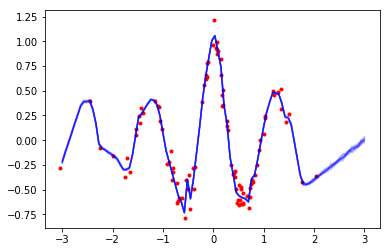

alpha=1
train step:0, train loss:0.260019451379776
train step:10000, train loss:0.021622013300657272
train step:20000, train loss:0.018298668786883354
train step:30000, train loss:0.017644772306084633
train step:40000, train loss:0.01830977573990822
train step:50000, train loss:0.01584743522107601


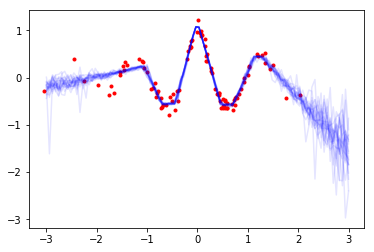

In [5]:
main(0)
main(1)